# Motivation

The purpose of this exploration is to see if we can create a topic model that will effectively differentiate the different types of job postings on LinkedIn. My hypothesis is that there are a few different types of advertisements, most likely seperated by industry and by skill set required.<br><br>
It is also possible that this data set does not have unique enough topics that the model will be able to distinguish them.

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load Libraries

In [4]:
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

from src.features import build_features

import logging 
from pathlib import Path

import scipy
import pickle
import datetime
import numpy as np

logging.basicConfig(level=logging.ERROR)

In [3]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim import corpora
import gensim
from gensim.utils import simple_preprocess

import re

from nltk.corpus import stopwords
from src.data.make_dataset import lematize

from sklearn.decomposition import TruncatedSVD

import pyLDAvis
import pyLDAvis.gensim 

from src.data.DBConnection import DBConnection
db = DBConnection()

# Build Features

In [5]:
sql = "SELECT details FROM positions;"
query = db.cur.execute(sql)
documents = query.fetchall()

In [7]:
def process_documents(documents):
    # try new preprocessing steps:
    data = list(documents)
    # remove \n
    data = [text[0].replace("\n", " ") for text in data]
    # remove https:// links 
    data = [re.sub(r"((https{0,1}\:/\/\w{3}\S+)|(w{3}\S+))", "", text) for text in data]
    # remove emails:
    data = [re.sub(r"(\S+@\S+)", "", text) for text in data]
    # remove phone numbers:
    data = [re.sub(r"([\+\s01-]*\(*\d{3}\)*[-\s]\d{3}[-\s]\d{4})", "", text) for text in data]
    # remove uf0b7
    data = [re.sub(r"(\uf0b7)", "", text) for text in data]
    # remove handles:
    data = [re.sub(r"(\@\S+)", "", text) for text in data]
    # remove french documents
    data = [doc for doc in data if "une" not in doc and "connaissance" not in doc]
    return data

def docs_to_words(documents):
    for doc in documents:
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [87]:
# get stop words and add some super-common words amoung the documents
stop_words = stopwords.words('english')
stop_words.extend(["data", "analytics", "team", "experience", "work", "business", "technology", "information"])

# clean all the documents (i.e., use regex to remove emails, urls, phone numbers, french documents, etc.)
clean_docs = process_documents(documents)

# use simple_preprocess to remove punctuation:
data_words = list(docs_to_words(clean_docs))

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form trigrams:
data_words_trigrams = make_trigrams(data_words_bigrams)

# Lematize docs:
data_lemmatized = [lematize(words).split(" ") for words in data_words_trigrams]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
# Create Dictionary
id2word = Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# PCA
See if PCA might be useful, also will be used to visualize the LDA model later.

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


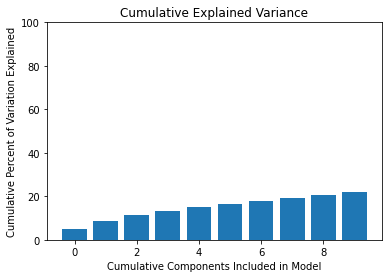

In [90]:
# initialize PCA:
# reduce features:
pca = PCA(n_components=10)
dense_corpus = gensim.matutils.corpus2dense(corpus, len(id2word.keys()))
reduced_features = pca.fit_transform(dense_corpus.T)

# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(pca.explained_variance_ratio_)), height=np.cumsum(pca.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

In [91]:
import pandas as pd
loadings = pd.DataFrame(data=pca.components_, columns=id2word.values()).T
topics = pd.DataFrame()
for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
0,learn,management,model,analysis,research,client,help,risk,agoda,product
1,model,support,machine,analytical,analysis,solution,client,model,opportunity,user
2,machine,report,solution,product,learn,product,people,use,learn,process
3,use,skill,skill,customer,skill,ibm,game,investment,solution,statistical
4,customer,provide,develop,model,client,analysis,learn,game,risk,engineering
5,build,process,learn,insight,health,use,solution,omers,machine,apply
6,solution,project,knowledge,statistical,ability,agoda,create,build,climate,requirement
7,help,client,management,stakeholder,statistical,drive,day,insight,world,disability
8,develop,analyst,technique,skill,game,market,like,analysis,development,security
9,science,ability,service,support,project,insight,problem,office,people,technical


It looks like PC0 might be dominated by descriptions that have a customer base while PC1 is more for managment support.

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


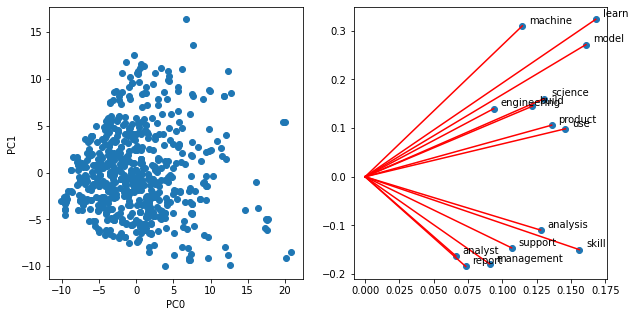

In [104]:
# plot loadings and score:
x = 0
y = 1
threshold = 0.16

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
plt.scatter(
    x=reduced_features[:,x], y=reduced_features[:,y]
)
ax1.set_xlabel(f"PC{x}")
ax1.set_ylabel(f"PC{y}")

ax2 = fig.add_subplot(1, 2, 2)
loadings_plot = loadings[(loadings[x]**2 + loadings[y]**2)**0.5 > threshold][[x, y]]
plt.scatter(x=loadings_plot[x], y=loadings_plot[y])
for label, (_x, _y) in loadings_plot.iterrows():
    plt.plot([0, _x], [0,_y], 'r')
    plt.text(_x+0.005, _y+0.005, label)

It's not immediately obvious what the PC's can really tell us. Let's see if an SVD model fares any better.

# SVD

In [93]:
svd_model = TruncatedSVD(n_components=6,         # num dimensions
                         algorithm='randomized',
                         n_iter=10)
svd_matrix = svd_model.fit_transform(dense_corpus.T)

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


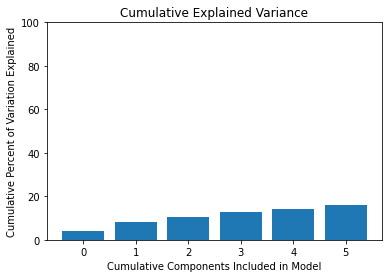

In [94]:
# display percent explained variance of the first ten components:
plt.figure()
plt.bar(x=range(len(svd_model.explained_variance_ratio_)), height=np.cumsum(svd_model.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

In [96]:
loadings = pd.DataFrame(data=svd_model.components_, columns=id2word.values()).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5
0,learn,learn,model,analysis,research,client
1,model,machine,machine,analytical,analysis,solution
2,skill,model,solution,product,skill,product
3,use,science,skill,customer,ability,ibm
4,product,build,develop,model,health,analysis
5,service,engineering,learn,insight,product,use
6,science,ml,management,statistical,science,agoda
7,solution,scientist,knowledge,stakeholder,statistical,drive
8,analysis,ai,service,skill,agoda,market
9,industry,product,client,report,analyst,insight


# LDA

In [97]:
logging.getLogger().setLevel(logging.CRITICAL)

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


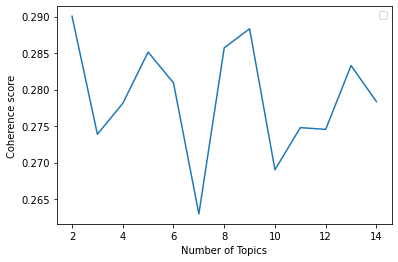

In [98]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# determine optimal number of topics using coherence score:
coherence_vals = []
model_list =[]
start = 2
stop = 15
step = 1

for num_topics in range(start, stop, step):
    # make LDa model and calc coherence:
    model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v', processes=1)
    coherence_vals.append(coherence_model.get_coherence())
    
x = range(start, stop, step)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend()

In [109]:
best_model = model_list[coherence_vals.index(max(coherence_vals))]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
best_model = model_list[3]
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
vis

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.006140 -0.002280       1        1  32.059442
0      0.000835 -0.006050       2        1  31.231479
3     -0.004331  0.006420       3        1  17.281211
1      0.003264 -0.002152       4        1  12.369484
4      0.006372  0.004062       5        1   7.058385, topic_info=            Term         Freq        Total Category  logprob  loglift
189        skill  1244.000000  1244.000000  Default  30.0000  30.0000
11      analysis  1025.000000  1025.000000  Default  29.0000  29.0000
438        model  1163.000000  1163.000000  Default  28.0000  28.0000
121      machine   837.000000   837.000000  Default  27.0000  27.0000
112        learn  1244.000000  1244.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
108          job    59.764790  1015.721693   Topic5  -5.4972  -0.1820
56   development    50.660127   785.186508   Topic5  -5.6625  -0.0898
283         help    49.894677   853.746870   Topic5  -5.6777  -0.1888
163      process    49.067274   846.248959   Topic5  -5.6945  -0.1967
208         tool    47.805568   797.407335   Topic5  -5.7205  -0.1633

[448 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.281036  ability
0         2  0.439724  ability
0         3  0.113868  ability
0         4  0.098120  ability
0         5  0.067836  ability
...     ...       ...      ...
6579      1  0.113736     zola
6579      2  0.341208     zola
6579      3  0.227472     zola
6579      4  0.113736     zola
6579      5  0.227472     zola

[1162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2, 5])

In [108]:
# display topics:
topic_dist = pd.DataFrame(data=best_model.get_topics(), columns=id2word.values()).T
lda_topics = pd.DataFrame()

for topic in topic_dist.columns:
    lda_topics[f"topic_{topic}"] = topic_dist[topic].sort_values(ascending=False)[:5].index
    
lda_topics

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,learn,skill,service,learn,learn,skill,model,learn,use
1,model,industry,model,skill,analysis,work,skill,product,learn
2,analysis,use,science,service,science,project,learn,skill,time
3,skill,job,product,use,use,analysis,product,model,model
4,machine,time,skill,build,solution,process,develop,analysis,industry


c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


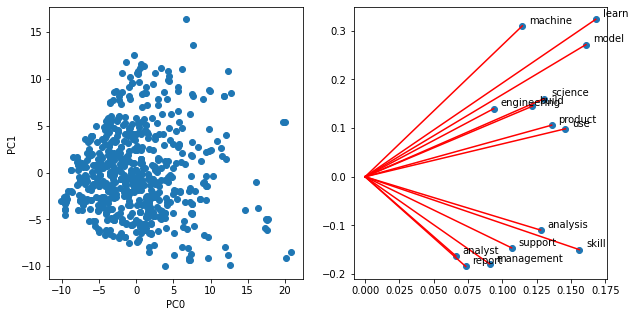

In [105]:
fig

# Observations

It looks like the topics are not well modelled, and I suspect that the dataset contains only similar documents, and therefore there are not inherent topics. This dataset might do well as a training algorithm to CREATE job postings.